In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import utils, callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

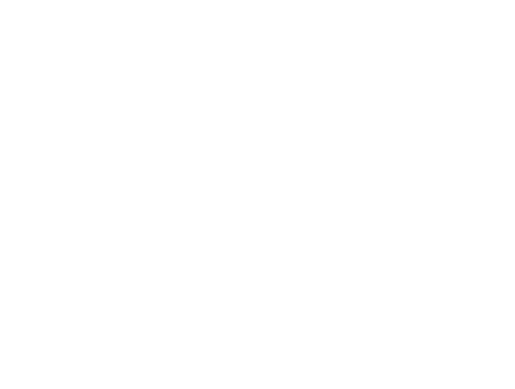

In [2]:
# globals
batch_size = 32
am_epochs = 100
am = 5287
am_steps = am//batch_size

# set random state
rs = 42
np.random.seed(42)

# image/chromagram dimensions
x_dim = 464 # 474
y_dim = 12 # 12

plt.axis('off')

checkpoint_filepath = '/kaggle/working/Checkpoint/'

In [3]:
# load every image with imgwrite
path = "/kaggle/input/chromagrams3/chromagrams3/"
image_names = os.listdir(path)[:am]
assert len(image_names) == am

In [4]:
# Make this an infinite generator
def gen(img_names):
    
  images = np.zeros((batch_size,y_dim,x_dim), dtype=np.float64)

  while True:

    i = 0

    while i < len(img_names):
      complete_path = path + img_names[i]
      images[i%batch_size,:,:] = cv2.imread(complete_path, cv2.IMREAD_GRAYSCALE)[:y_dim,:x_dim]/255
      i += 1
      if i%batch_size == 0:
        images = images.reshape(batch_size, y_dim, x_dim, 1)
        yield (images, images)
        images = np.zeros((batch_size,y_dim,x_dim), dtype=np.float64)


In [5]:
data = gen(image_names)

In [6]:
def imshow(img):
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
    plt.figure(figsize=(30, 10))
    plt.imshow(img, cmap='gray')
    print(img.shape)
    plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
    plt.show()

(12, 464, 1)


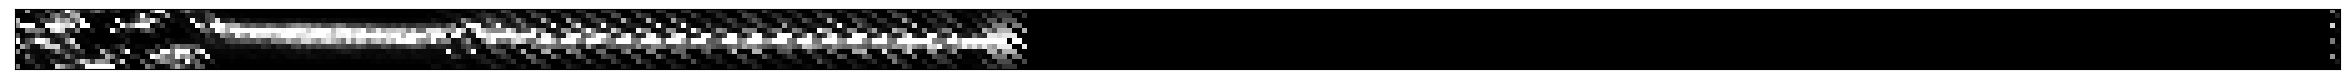

In [7]:
imgs = next(data)
img  = imgs[0][rs%batch_size]

imshow(img)

In [8]:
def get_model(am_features):
    
    xin = Input(shape=(y_dim,x_dim,1))
    x = Conv2D(3, (7, 19), activation='relu', padding='same', strides=(2,2))(xin)
    x = Conv2D(3, (7, 19), activation='relu', padding='same', strides=(2,2))(x)
    x = Conv2D(2, (7, 19), activation='relu', padding='same', strides=(1,2))(x)
    x = Reshape((3*58*2,))(x)
    
    # only add intermediate layer if the feature space is small enough
    if am_features <= 100:
        x = Dense(150, activation='relu')(x)
    
    encoded = Dense(am_features, activation='sigmoid')(x)

    decoder_in = Input(shape=(am_features,))
    y = Dense(150, activation='relu')(decoder_in)
    y = Dense(3*58*2, activation='relu')(y)
    y = Reshape((3,58,2))(y)
    y = UpSampling2D((1, 2))(y)
    y = Conv2D(2, (7, 19), padding='same', activation='relu')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(3, (7, 19), padding='same', activation='relu')(y)
    y = UpSampling2D((2, 2))(y)
    decoded = Conv2D(1, (7, 19), padding='same', activation='sigmoid')(y)

    encoder = Model(xin, encoded)
    decoder = Model(decoder_in, decoded)

    auto_input = Input(shape=(y_dim,x_dim,1))
    encoded = encoder(auto_input)
    decoded = decoder(encoded)

    model = Model(auto_input, decoded)

    model.compile(optimizer='adam', loss='MeanSquaredError') # 'binary_crossentropy'
    
    model.summary()

    return model, encoder, decoder

In [9]:
def train_model(model, encoder, decoder):
    
    def plot_history(model_history, keys):
        m,val_m = keys
        plt.plot(model_history.history[m])
        #plt.plot(model_history.history[val_m])
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
        
    # clear checkpoint before training
    if os.path.exists(checkpoint_filepath):
        for f in os.listdir(checkpoint_filepath):
            os.remove(os.path.join(checkpoint_filepath, f))
            
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        save_best_only=True)
    
    history = model.fit(data, 
                    epochs=am_epochs, 
                    steps_per_epoch=am_steps,
                    callbacks=[model_checkpoint_callback])
    
    plot_history(history,['loss','val_loss'])
    
    model.load_weights(checkpoint_filepath)
    
    model_save_path = "/kaggle/working/saves/" + str(am_features)

    model.save(model_save_path + "/model/")
    encoder.save(model_save_path + "/encoder/")

    model.load_weights(model_save_path + "/model/")
    encoder.load_weights(model_save_path + "/encoder/")
    
    
    # Let's see if the results are satisfactory    
    batch = next(data)[0]
    auto_encoder_imgs = model.predict(batch)

    img = batch[rs%batch_size]
    img2 = auto_encoder_imgs[rs%batch_size]

    encoder_imgs = encoder.predict(batch)
    decoder_imgs = decoder.predict(encoder_imgs)
    img3 = decoder_imgs[rs%batch_size]

    imshow(img) # normal image
    imshow(img2) # image run through autoencoder
    imshow(img3) # image run through encoder and then through decoder

    # difference between original and autoencoder img
    print(np.sum(abs(img-img2)))
    print(np.sum((img-img2)*(img-img2)/(x_dim*y_dim)))

    # difference between autoencoder img and encoder-decoder img
    print(np.sum(abs(img3-img2)))
    print(np.sum((img3-img2)*(img3-img2)/(x_dim*y_dim)))
    
    return model, encoder, decoder

In [10]:
def output_metrics(encoder):
    
    # extract the entire dataset into a numpy array of (batch_size*am_batches, am_features) 
    # with batch_size*am_batches being close to am_chromograms

    encoded_all = encoder.predict(data, steps=am_steps)

    assert encoded_all.shape[0] == am_steps*batch_size

    distances = []
    for i in range(batch_size*am_steps):
        for j in range(i):
            distances.append(np.inner(encoded_all[i,:], encoded_all[j,:]))

    assert min(distances) >= 0
    assert max(distances) <= am_features

    distances = np.array(distances)
    print(distances.shape)

    # plotting the distributions of the distances between the encoded vectors
    plt.hist(distances, bins=1000, range=(0, am_features))
    
    
    # getting the cluster diagrams
    cluster_number = range(2,20) 

    distortions = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    for n in cluster_number:
        estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
        y = estimator.fit_predict(encoded_all)
        distortions.append(estimator.inertia_)
        silhouette_scores.append(silhouette_score(encoded_all,y))
        calinski_harabasz_scores.append(calinski_harabasz_score(encoded_all,y))
    
    t = cluster_number
    data1 = distortions
    data2 = calinski_harabasz_scores #silhouette_scores

    fig, ax1 = plt.subplots(figsize = (15, 10))

    color = 'tab:red'
    ax1.set_xlabel('number of clusters')
    ax1.set_ylabel('inertia', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('calinski_harabasz_scores', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

-----------------------------------------------------------------
| Feature space of: 10
-----------------------------------------------------------------
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 464, 1)]      0         
                                                                 
 model (Functional)          (None, 10)                56262     
                                                                 
 model_1 (Functional)        (None, 12, 464, 1)        55933     
                                                                 
Total params: 112,195
Trainable params: 112,195
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
165/165 [==============================] - 31s 114ms/step - loss: 0.0515
Epoch 2/100
165/165 [==============================] - 6s 38ms/step - loss: 0

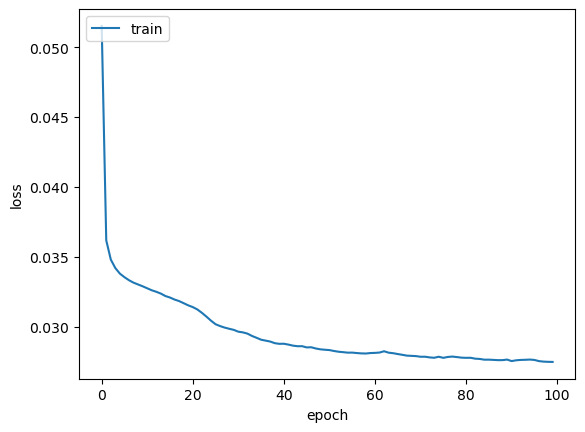

1/1 [==============================] - 0s 142ms/step
(12, 464, 1)


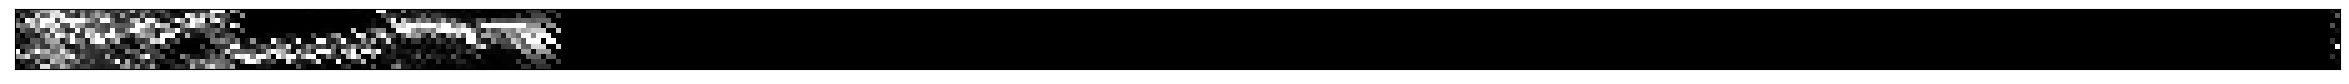

(12, 464, 1)


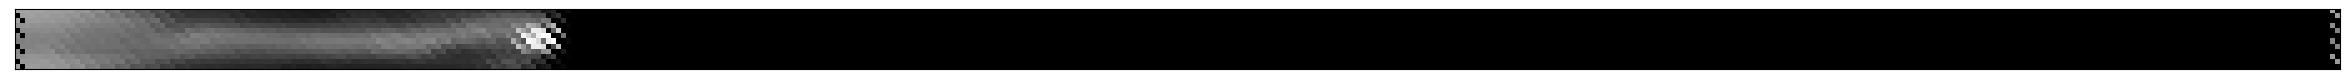

(12, 464, 1)


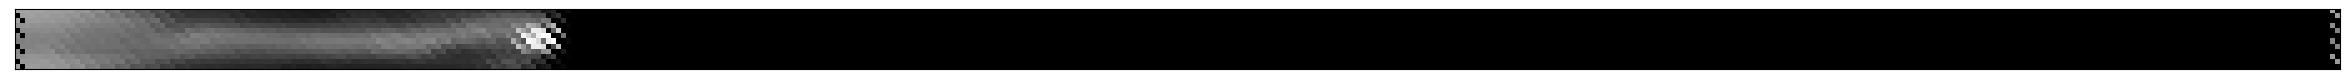

318.64202104017124
0.021121318813974284
0.0
0.0
165/165 [==============================] - 5s 32ms/step
(13936560,)


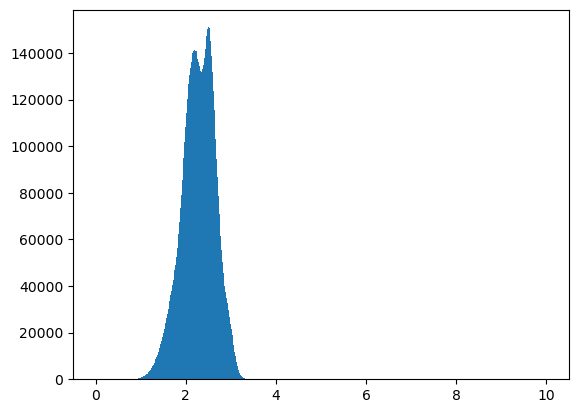

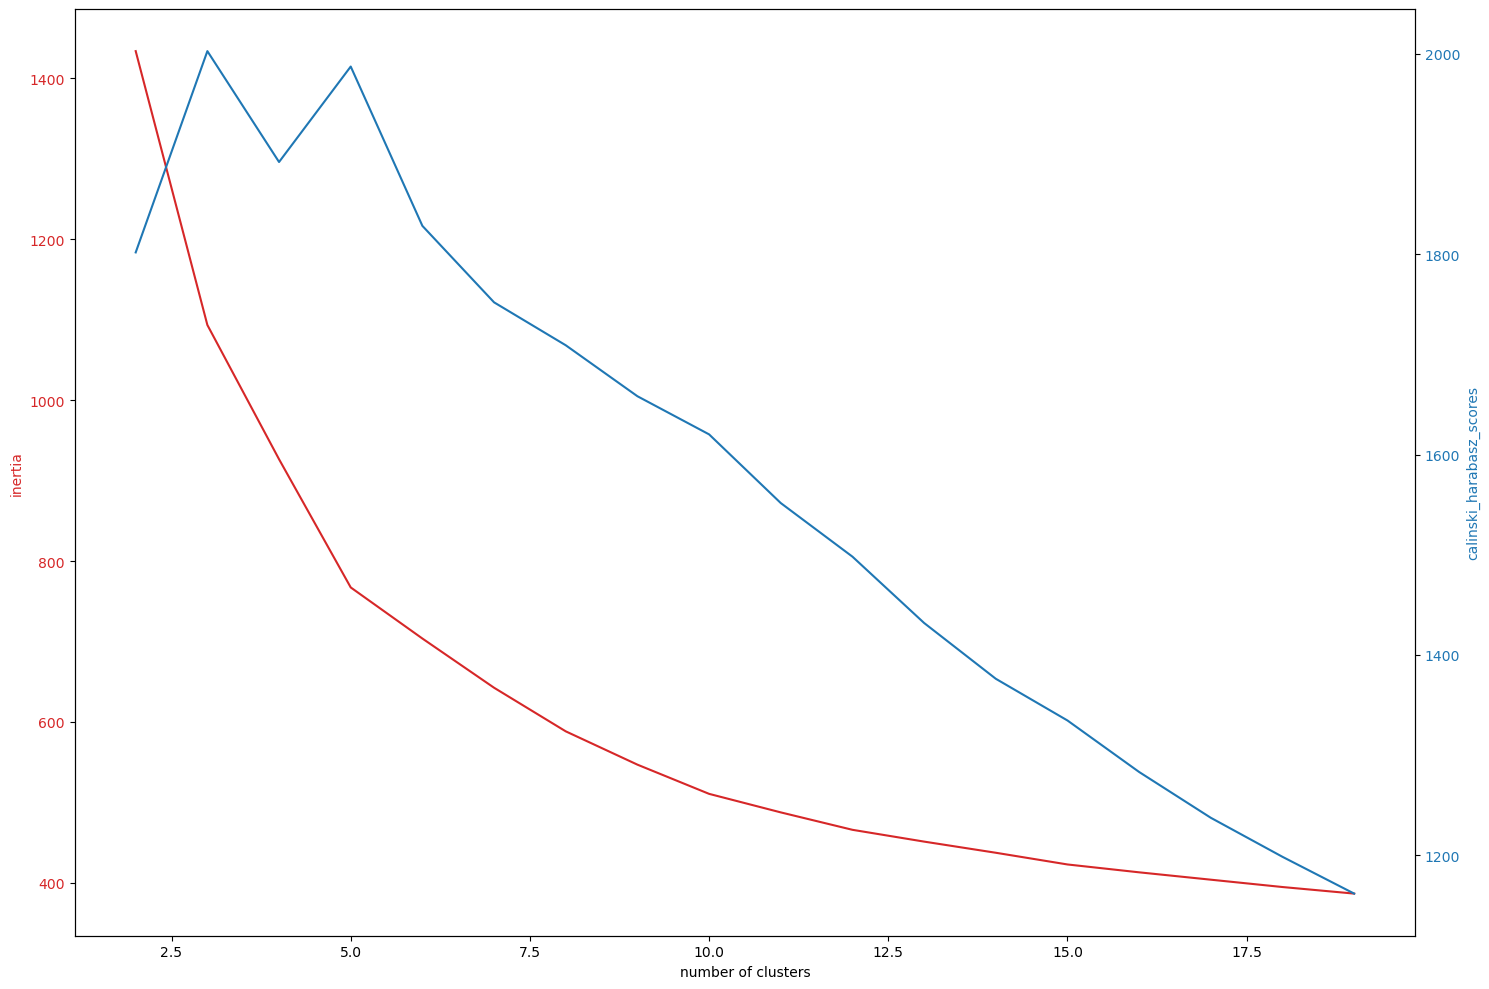

-----------------------------------------------------------------
| Feature space of: 25
-----------------------------------------------------------------
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12, 464, 1)]      0         
                                                                 
 model_3 (Functional)        (None, 25)                58527     
                                                                 
 model_4 (Functional)        (None, 12, 464, 1)        58183     
                                                                 
Total params: 116,710
Trainable params: 116,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
165/165 [==============================] - 9s 35ms/step - loss: 0.0494
Epoch 2/100
165/165 [==============================] - 5s 33ms/step - loss: 0.0

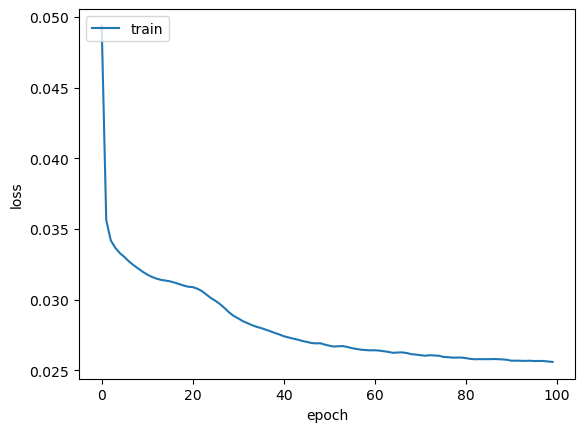

1/1 [==============================] - 0s 86ms/step
(12, 464, 1)


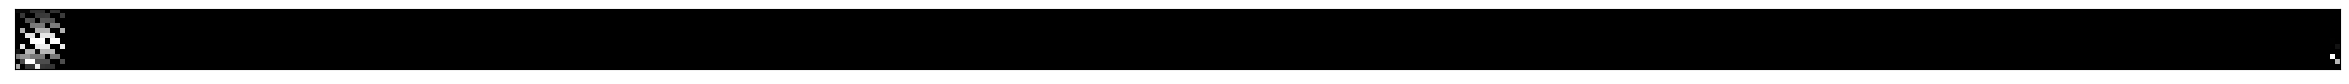

(12, 464, 1)


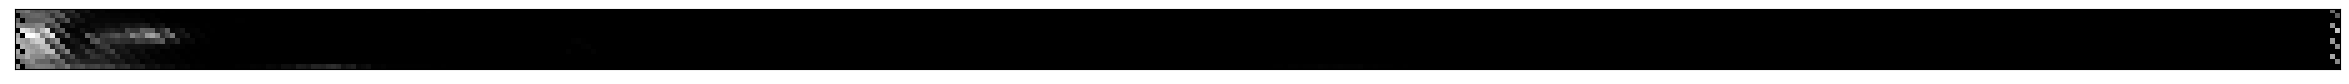

(12, 464, 1)


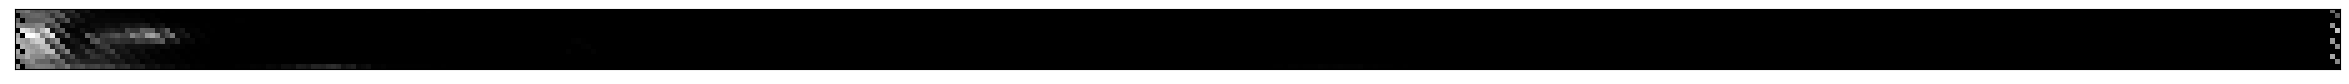

49.282653600330804
0.002494775666506941
0.0
0.0
165/165 [==============================] - 5s 33ms/step
(13936560,)


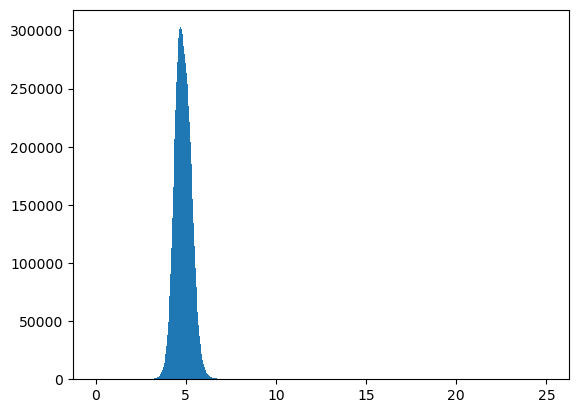

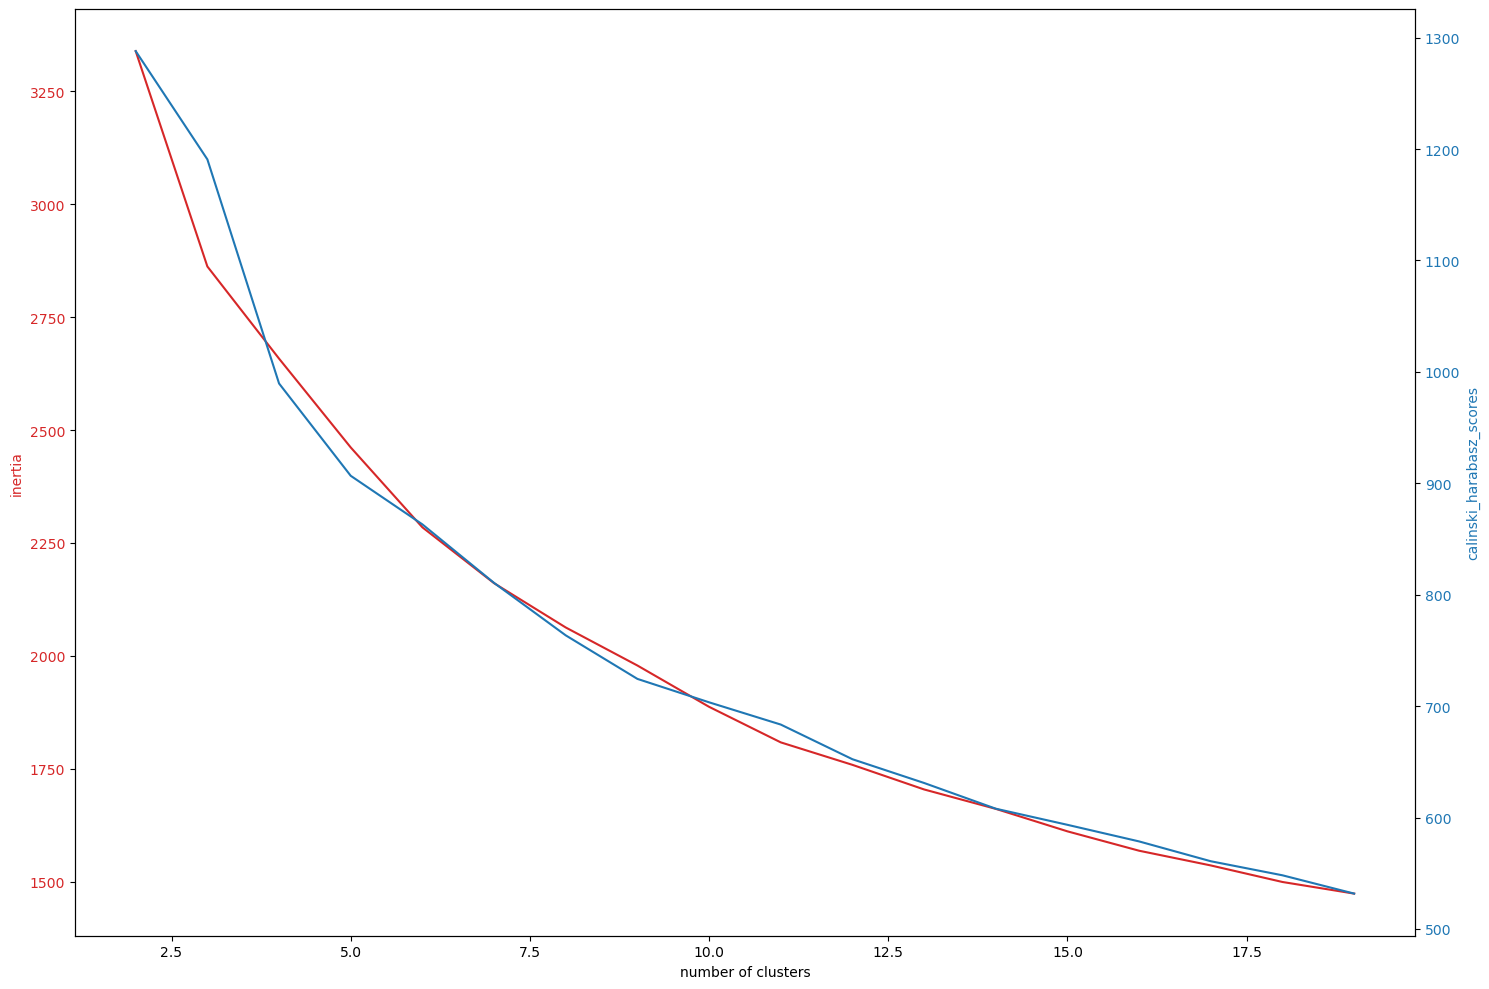

-----------------------------------------------------------------
| Feature space of: 35
-----------------------------------------------------------------
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 12, 464, 1)]      0         
                                                                 
 model_6 (Functional)        (None, 35)                60037     
                                                                 
 model_7 (Functional)        (None, 12, 464, 1)        59683     
                                                                 
Total params: 119,720
Trainable params: 119,720
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
165/165 [==============================] - 9s 34ms/step - loss: 0.0496
Epoch 2/100
165/165 [==============================] - 6s 34ms/step - loss: 0.0

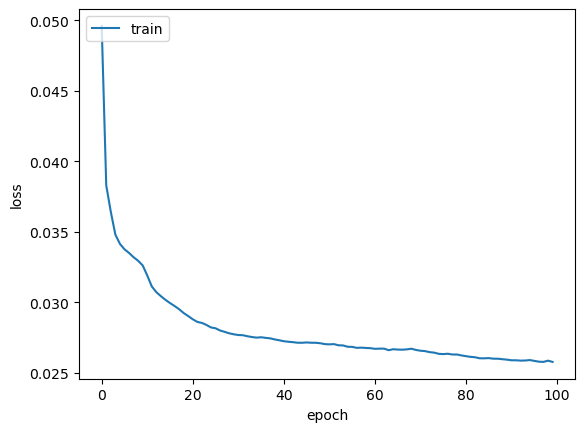

1/1 [==============================] - 0s 83ms/step
(12, 464, 1)


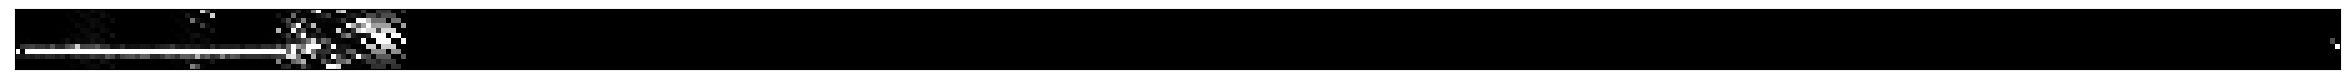

(12, 464, 1)


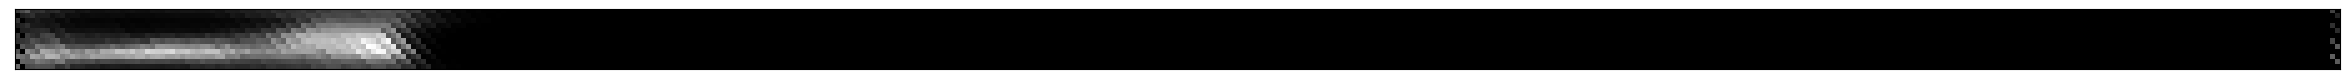

(12, 464, 1)


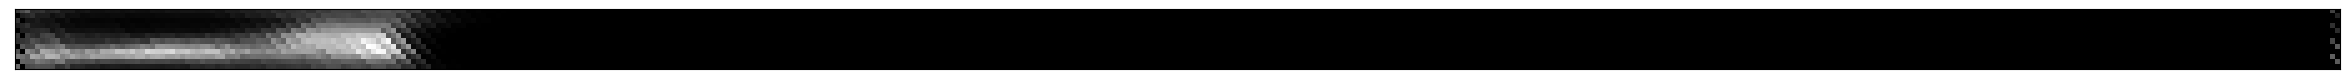

182.98032684307933
0.011323755732687416
0.0
0.0
165/165 [==============================] - 6s 34ms/step
(13936560,)


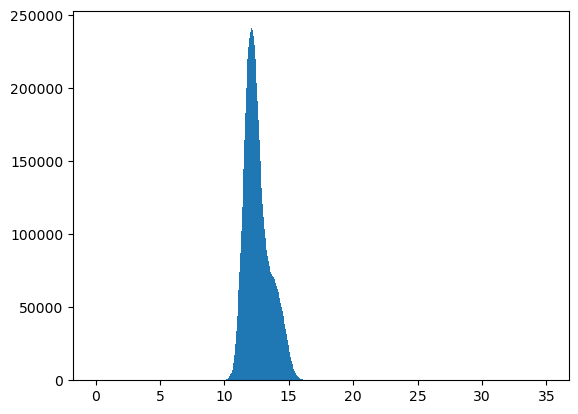

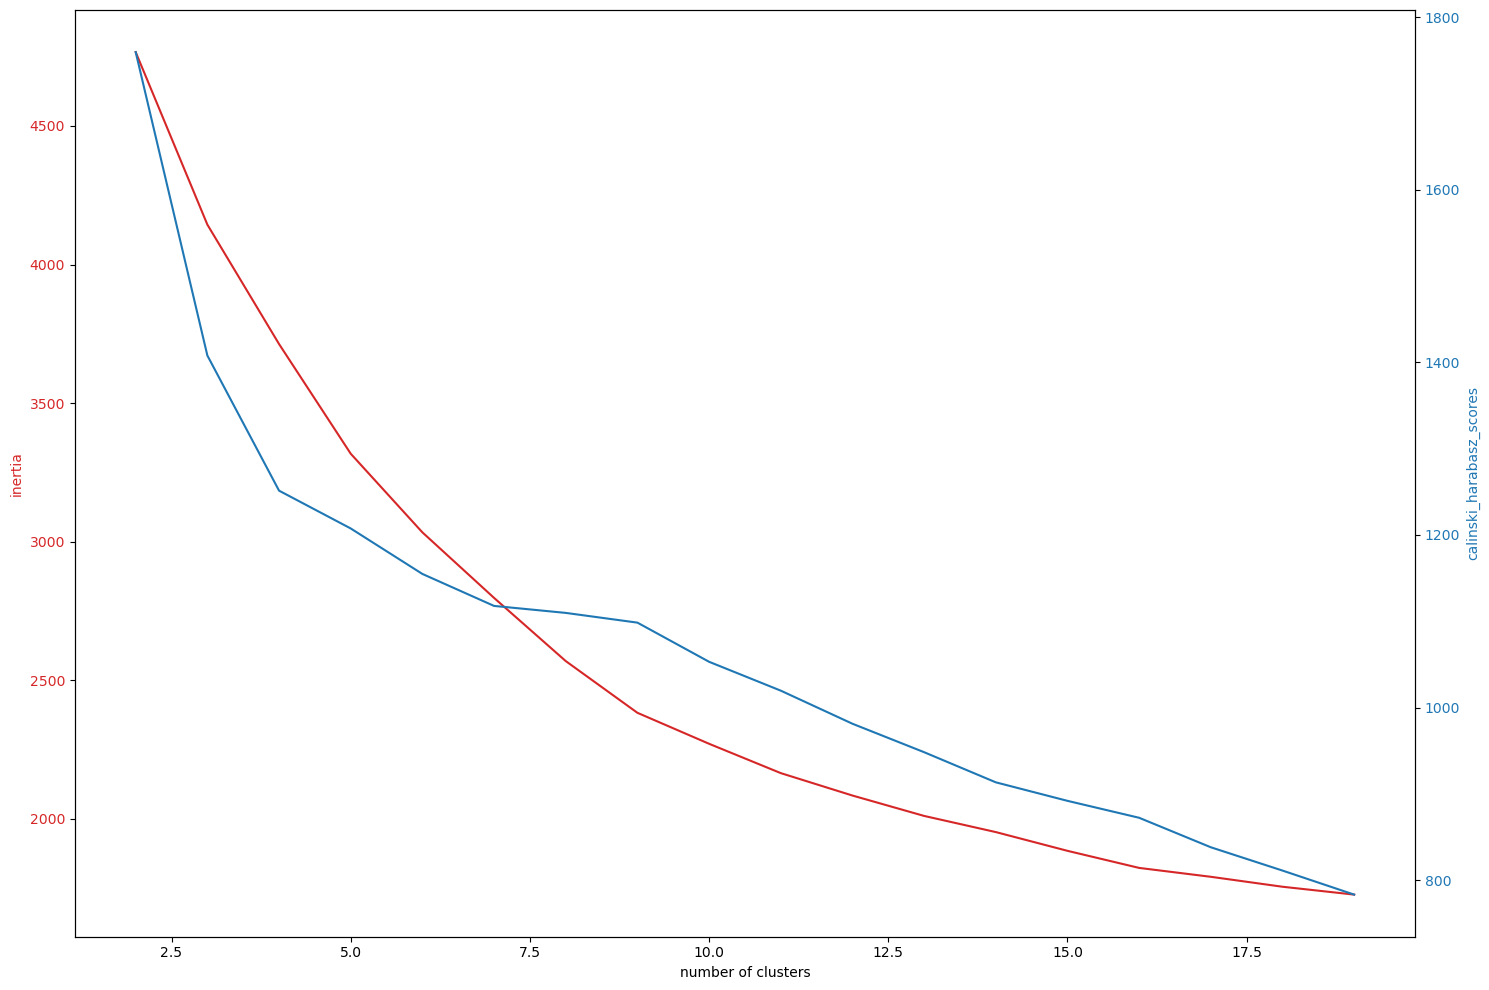

-----------------------------------------------------------------
| Feature space of: 50
-----------------------------------------------------------------
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 12, 464, 1)]      0         
                                                                 
 model_9 (Functional)        (None, 50)                62302     
                                                                 
 model_10 (Functional)       (None, 12, 464, 1)        61933     
                                                                 
Total params: 124,235
Trainable params: 124,235
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
165/165 [==============================] - 9s 35ms/step - loss: 0.0729
Epoch 2/100
165/165 [==============================] - 6s 35ms/step - loss: 0.

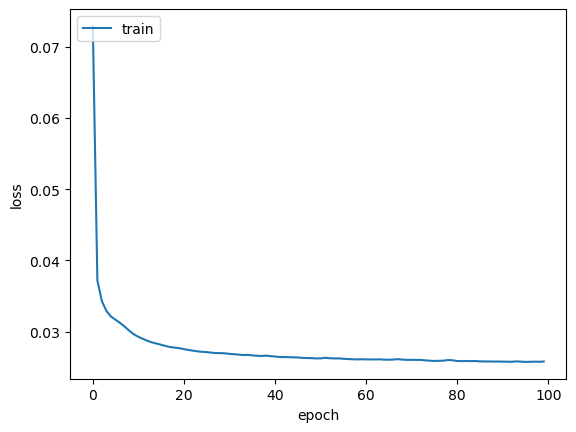

1/1 [==============================] - 0s 85ms/step
(12, 464, 1)


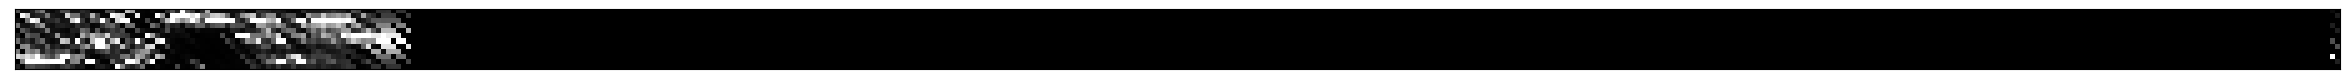

(12, 464, 1)


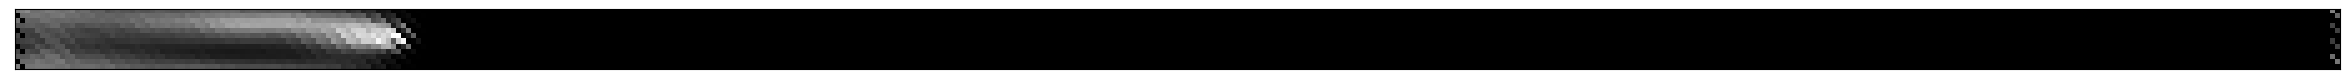

(12, 464, 1)


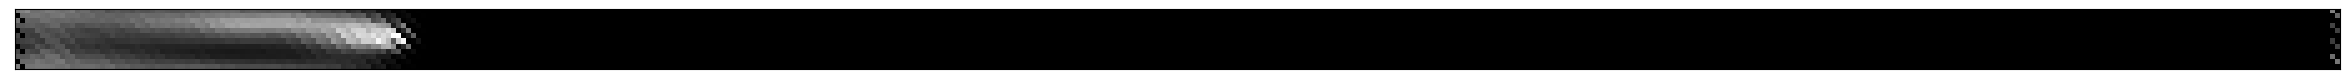

215.60157357010428
0.014417053388443849
0.0
0.0
165/165 [==============================] - 6s 33ms/step
(13936560,)


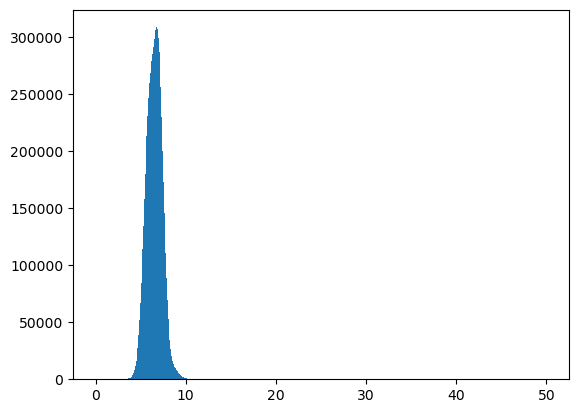

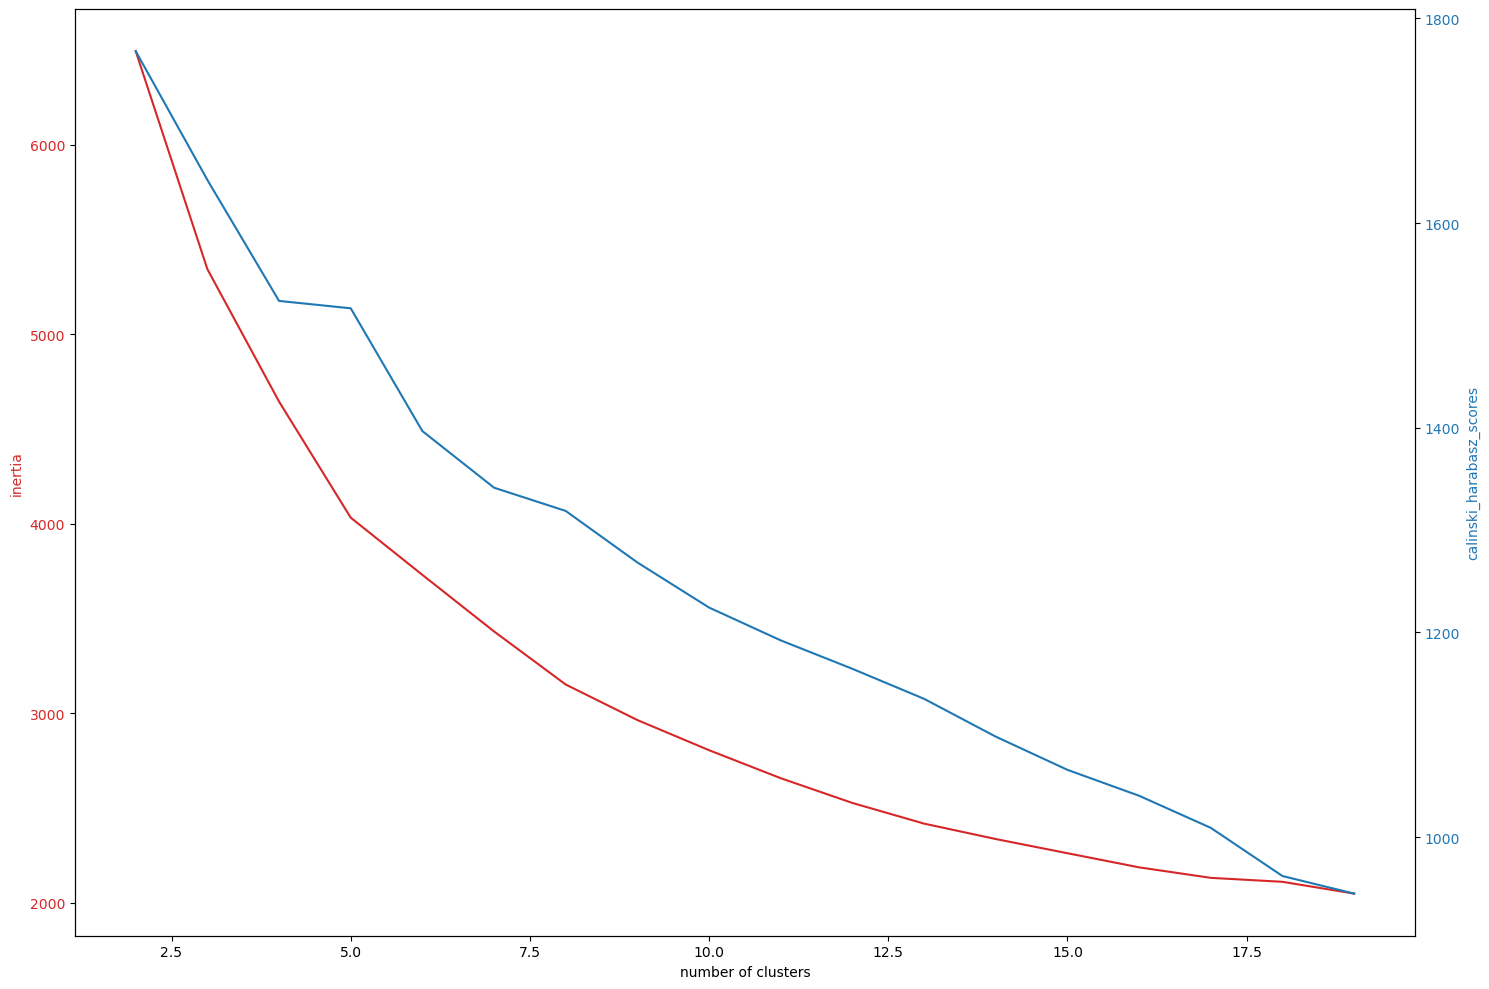

-----------------------------------------------------------------
| Feature space of: 100
-----------------------------------------------------------------
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 12, 464, 1)]      0         
                                                                 
 model_12 (Functional)       (None, 100)               69852     
                                                                 
 model_13 (Functional)       (None, 12, 464, 1)        69433     
                                                                 
Total params: 139,285
Trainable params: 139,285
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
165/165 [==============================] - 9s 34ms/step - loss: 0.0467
Epoch 2/100
165/165 [==============================] - 6s 35ms/step - loss: 0

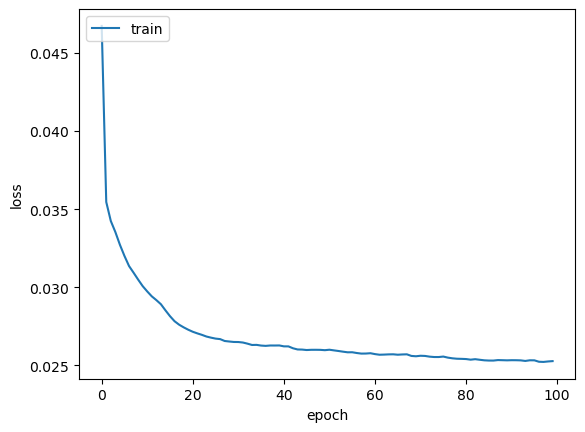

1/1 [==============================] - 0s 82ms/step
(12, 464, 1)


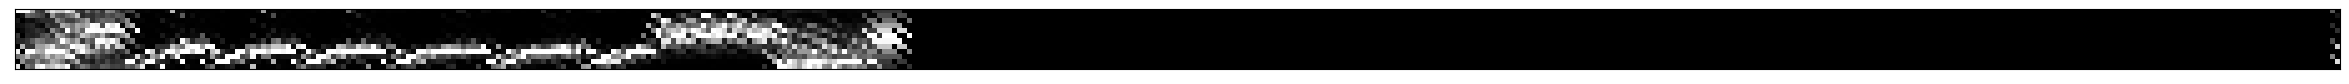

(12, 464, 1)


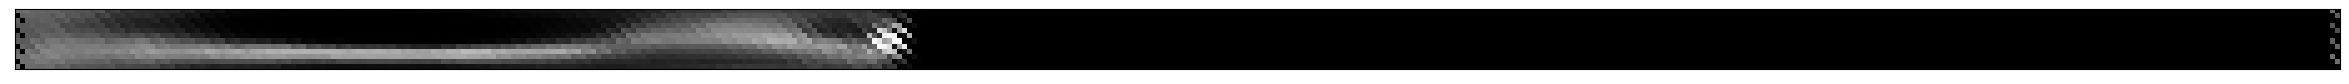

(12, 464, 1)


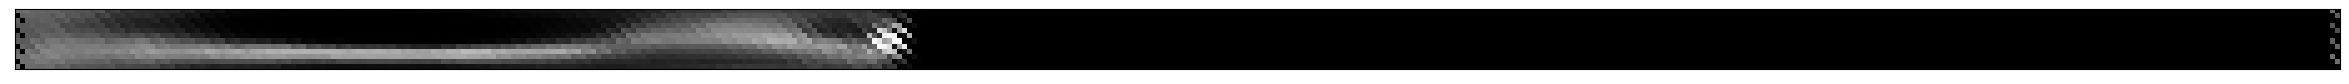

407.88858380903605
0.027384299121394874
0.0
0.0
165/165 [==============================] - 6s 38ms/step
(13936560,)


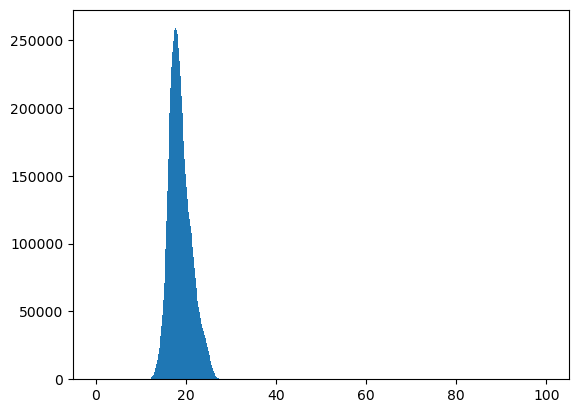

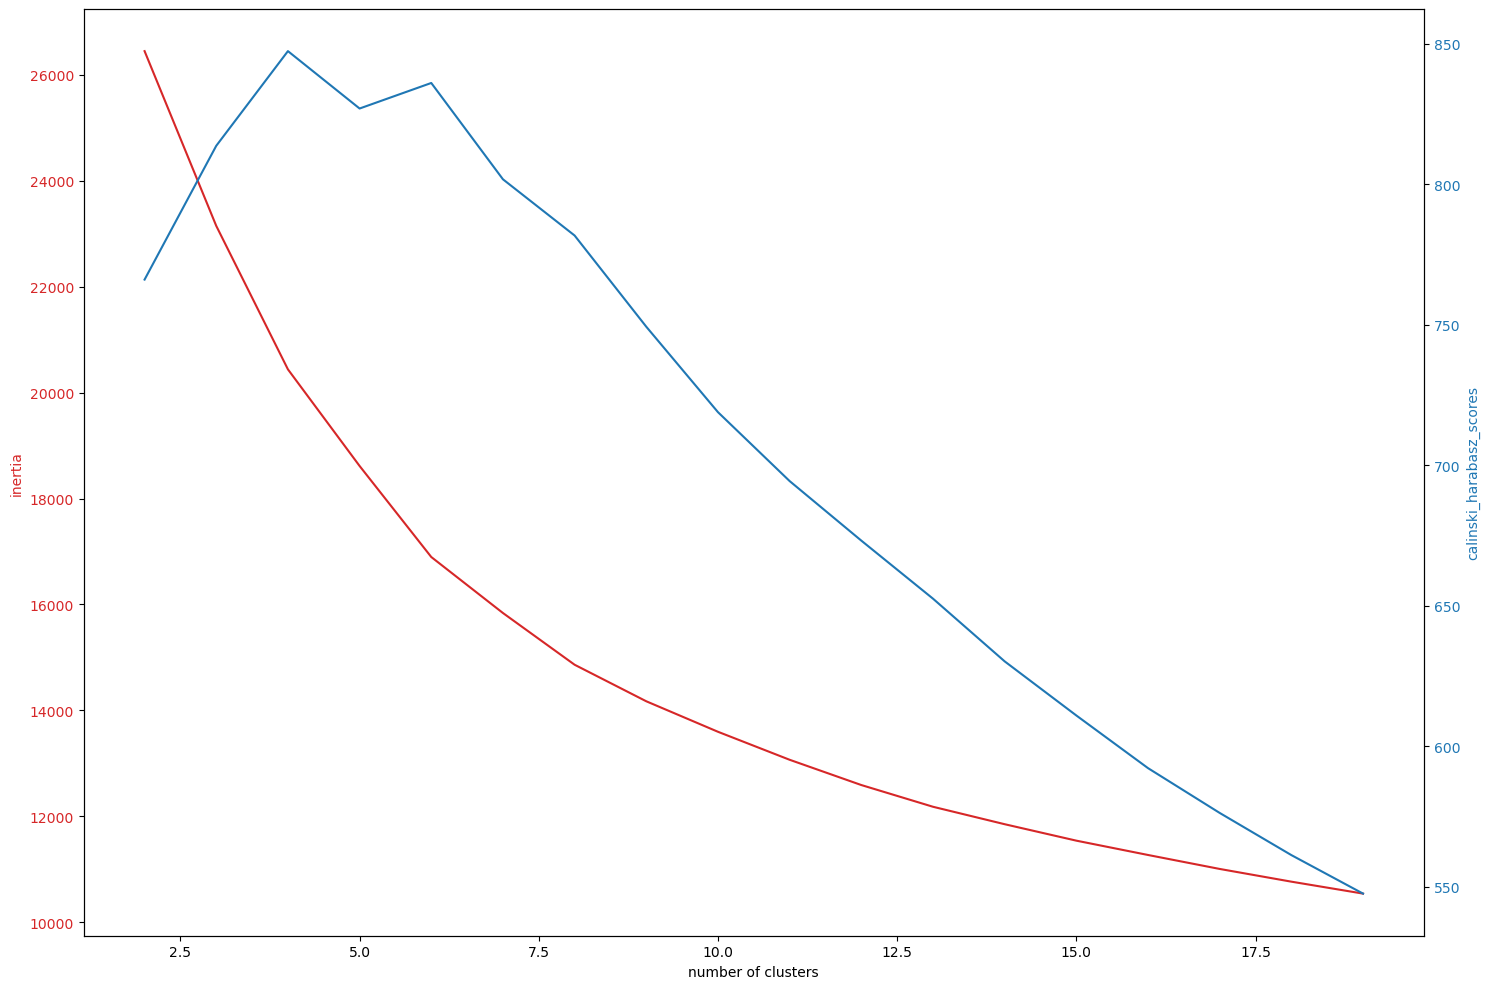

-----------------------------------------------------------------
| Feature space of: 600
-----------------------------------------------------------------
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 12, 464, 1)]      0         
                                                                 
 model_15 (Functional)       (None, 600)               211802    
                                                                 
 model_16 (Functional)       (None, 12, 464, 1)        144433    
                                                                 
Total params: 356,235
Trainable params: 356,235
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
165/165 [==============================] - 9s 38ms/step - loss: 0.0483
Epoch 2/100
165/165 [==============================] - 6s 36ms/step - loss: 0

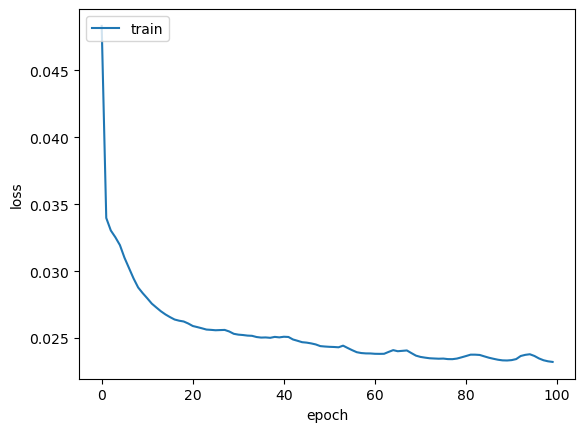

1/1 [==============================] - 0s 87ms/step
(12, 464, 1)


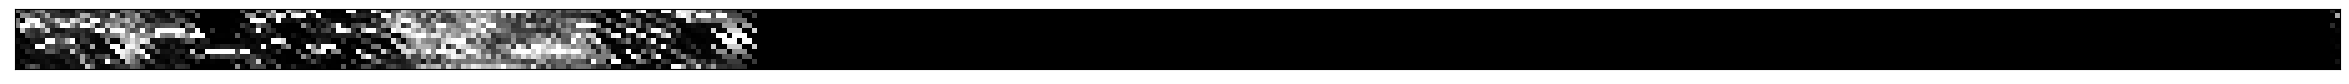

(12, 464, 1)


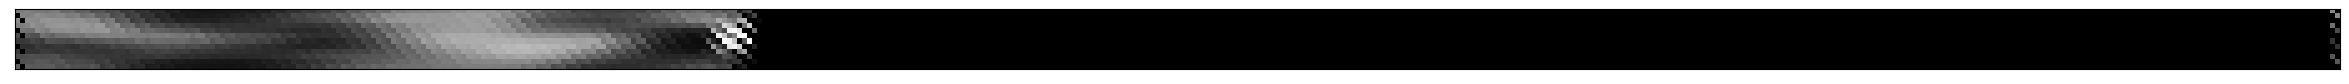

(12, 464, 1)


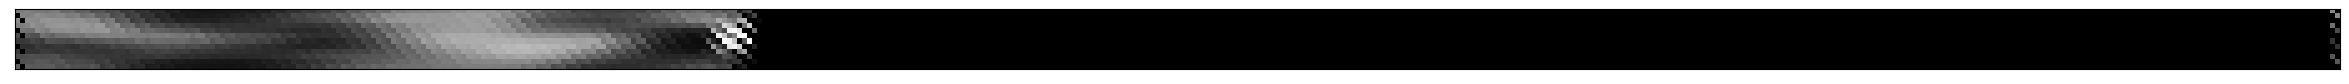

397.9751298320027
0.026029634747914487
0.0
0.0
165/165 [==============================] - 6s 34ms/step
(13936560,)


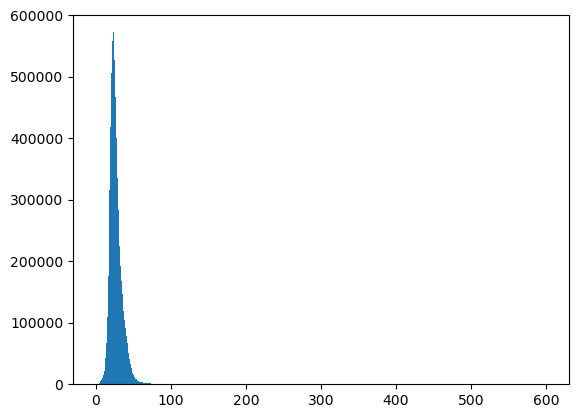

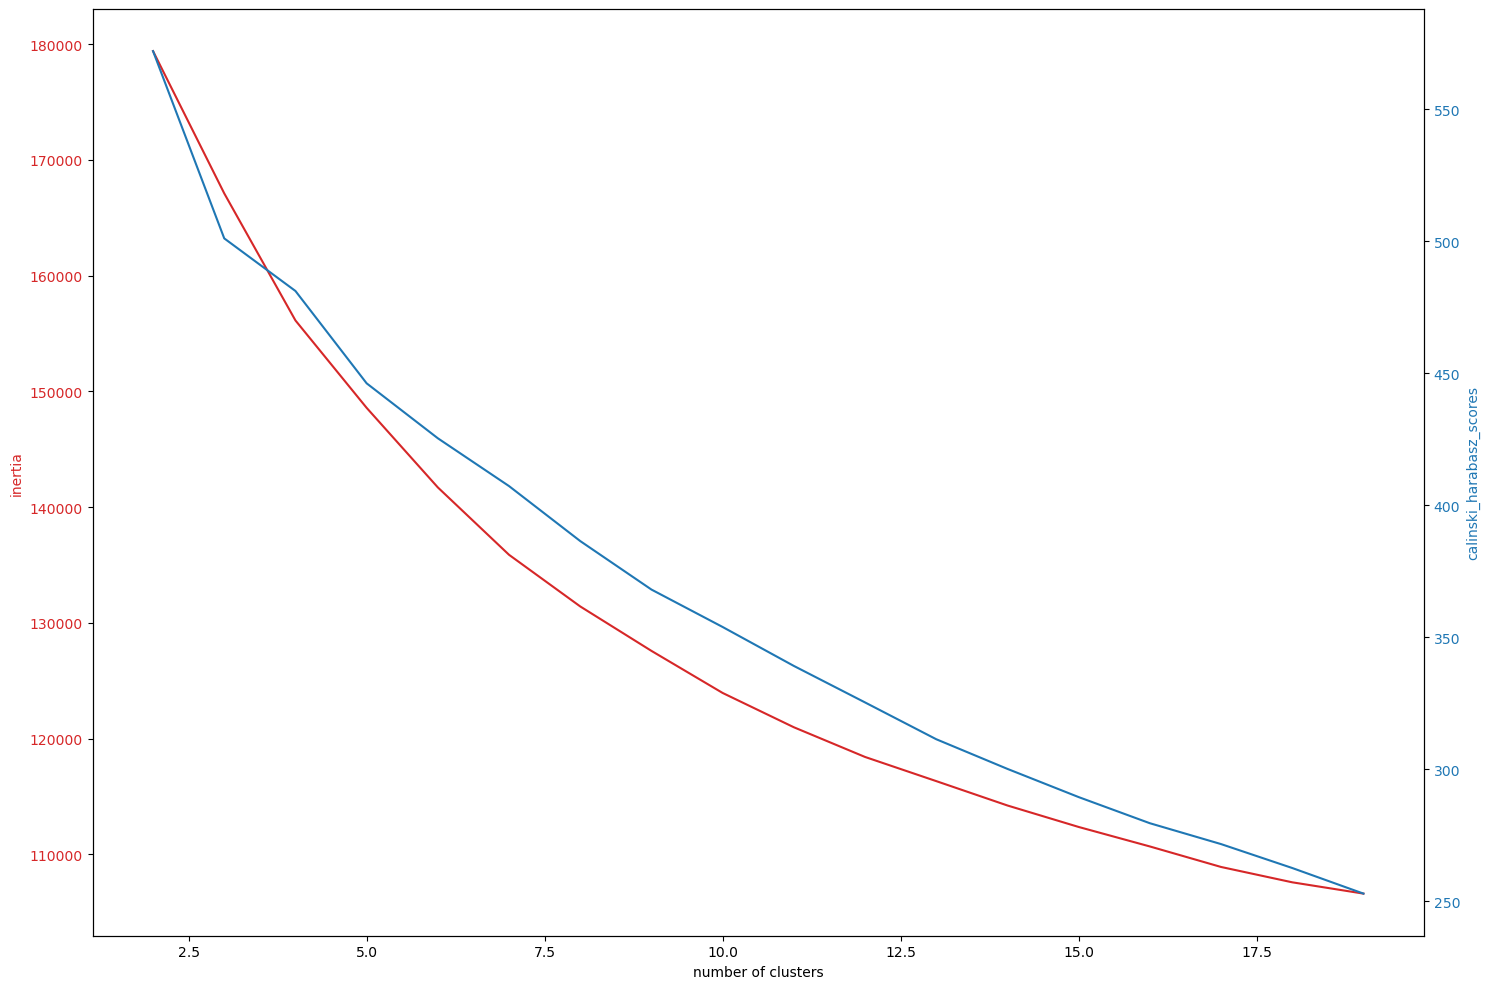

In [11]:
am_features_list = [10, 25, 35, 50, 100, 600]

for am_features in am_features_list:
    
    print("-----------------------------------------------------------------")
    print("| Feature space of:", am_features)
    print("-----------------------------------------------------------------")
    
    model, encoder, decoder = get_model(am_features)
    model, encoder, decoder = train_model(model, encoder, decoder)
    output_metrics(encoder)